In [1]:
import torch.nn as nn
import torch
    
class default_layer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(default_layer, self).__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3,1,1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.seq(x)  
    
class up_layer(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(up_layer,self).__init__()
        self.upsample = nn.Upsample(scale_factor=2)
        self.layer = default_layer(in_channels, out_channels)
        
    def forward(self,x):
        return self.layer(self.upsample(x))

class recurrent_layer(nn.Module):
    def __init__(self, channels):
        super(recurrent_layer, self).__init__()
        self.layer = default_layer(channels, channels)

    def forward(self, x):
        return self.layer(x + self.layer(x))  
    
class recurrent_block(nn.Module):
    def __init__(self,  in_channels, out_channels):
        super(recurrent_block, self).__init__()
        self.r2c = nn.Sequential(
            recurrent_layer(out_channels),
            recurrent_layer(out_channels)
        )
        self.conv1x1 = nn.Conv2d(in_channels,out_channels,1)
        
    def forward(self, x):
        x = self.conv1x1(x)
        return x + self.r2c(x)
    
class down_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(down_block, self).__init__()
        self.r2c = recurrent_block(in_channels,out_channels)
        self.maxpool = nn.MaxPool2d(2,2)

    def forward(self, x):
        x = self.r2c(x)
        return self.maxpool(x), x
    
class up_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(up_block, self).__init__()
        self.in_channels = in_channels
        self.up_layer = up_layer(in_channels, out_channels)
        self.r2c = recurrent_block(in_channels,out_channels)

    def forward(self, x, attachment):
        x = self.up_layer(x)
        
        x = torch.cat((attachment,x),dim=1)
        x = self.r2c( x)
        
        return x
    
class Segnet(nn.Module):
    def __init__(self, classes):
        super(Segnet, self).__init__()
        
        self.down_rcl1 = down_block(3, 64)
        self.down_rcl2 = down_block(64, 128)
        self.down_rcl3 = down_block(128, 256)
        self.down_rcl4 = down_block(256, 512)
        
        self.down_rcl5 = recurrent_block(512, 1024)
        
        self.up_rcl1 = up_block(1024, 512)
        self.up_rcl2 = up_block(512, 256)
        self.up_rcl3 = up_block(256, 128)
        self.up_rcl4 = up_block(128, 64)
        self.conv1x1 = nn.Conv2d(64,classes,1)

    def forward(self, x):
        x, a = self.down_rcl1(x)
        x, b = self.down_rcl2(x)
        x, c = self.down_rcl3(x)
        x, d = self.down_rcl4(x)
        x = self.down_rcl5(x)
        
        x = self.up_rcl1(x, d)
        x = self.up_rcl2(x, c)
        x = self.up_rcl3(x, b)
        x = self.up_rcl4(x, a)
        x = self.conv1x1(x)
        
        return x

In [2]:
from torch.utils import data
import os
import numpy as np
from PIL import Image
from torchvision import transforms

root = "/datasets/cityscapes/medium/train/"


mapping = [7,8,11,12,13,17,19,20,21,22,23,24,25,26,27,28,31,32,33]
#mapping = [7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33]


class cityscapes(data.Dataset):
    def __init__(self):
        self.tf = transforms.ToTensor()
        pass
    def __len__(self):
        return 2975
    def __getitem__(self, index):
        name = str(index).zfill(4) + ".png"
        input = Image.open(root + "input/" + name )
        target = Image.open(root + "target/" + name )
        
        inputTensor = self.tf(input)
        
        targetTensor = torch.from_numpy(np.array(target)).int()
        
        #targetResultTensor = torch.zeros((len(mapping), 256, 512), dtype=torch.float32)
        
        masks = []

        for i in mapping:
            masks.append(targetTensor == i)
        
        return inputTensor, torch.stack(masks).float()

dst = cityscapes()
trainloader = data.DataLoader(dst, batch_size = 1, num_workers = 10)

In [5]:
device = torch.device("cuda:7")
model = torch.load("r2u7.model", map_location=device)
model = model.train()


In [ ]:
#device = torch.device("cuda:7")
#model = Segnet(len(mapping)).to(device)

725 3700
tensor(-0.1440, grad_fn=<MinBackward1>)


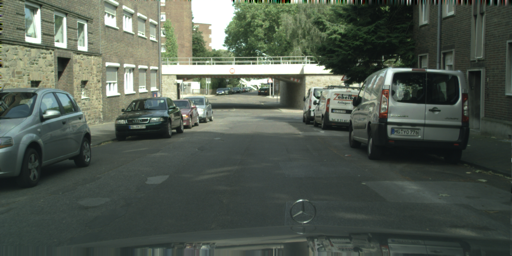

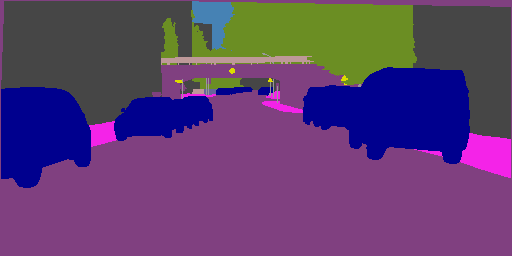

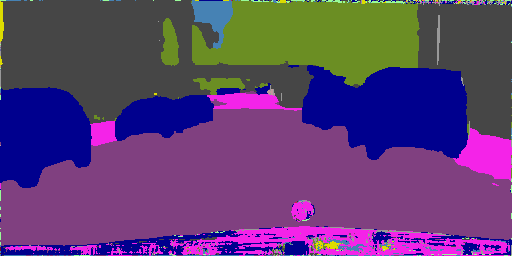

In [ ]:
import torch.optim as optim
from IPython.display import clear_output

#model = Segnet().to(device)

colors = torch.tensor([
    [128, 64,128],
    [244, 35,232],
    [ 70, 70, 70],
    [102,102,156],
    [190,153,153],
    [153,153,153],
    [250,170, 30],
    [220,220,  0],
    [107,142, 35],
    [152,251,152],
    [ 70,130,180],
    [220, 20, 60],
    [255,  0,  0],
    [  0,  0,142],
    [  0,  0, 70],
    [  0, 60,100],
    [  0, 80,100],
    [  0,  0,230],
    [119, 11, 32],
    [0,0,0]
]) / 255

# loss function
criterion = nn.MSELoss()
# optimizer variable
opt = optim.Adam(model.parameters())
count = 0

try:

    for _ in range(2000):
        for i, (inputs, targets) in enumerate(trainloader):
            #if loss != None and i % 50 == 0:
            inputs = inputs.to(device)
            targets = targets.to(device)

            opt.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            opt.step()  

            if count % 50 == 0:
                torch.save(model, "r2u11.model")

                outputs = outputs.cpu()
                targets = targets.cpu()


                indices = torch.argmax(outputs, 1)
                targetIndices = torch.argmax(targets, 1)

                colorImage = torch.stack([colors[indices, 0 ], colors[indices, 1], colors[indices, 2]], dim=1)
                targetImage = torch.stack([colors[targetIndices, 0 ], colors[targetIndices, 1], colors[targetIndices, 2]], dim=1)



                clear_output(wait=False)
                print(i, count)

                print(outputs.min())
                display(transforms.ToPILImage()( inputs[0] ))
                display(transforms.ToPILImage()( targetImage[0] ))
                display(transforms.ToPILImage()( colorImage[0] ))

                #display(transforms.ToPILImage()(outputs[0][1].cpu() ))
                #display(transforms.ToPILImage()(outputs[0][6].cpu() ))
                #display(transforms.ToPILImage()(outputs[0][15].cpu() ))
            count+=1

except KeyboardInterrupt:
    torch.save(model, "r2uSaved.model")

In [ ]:
import torch
torch.cuda.empty_cache() 

R2U_Net(
  (Maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Upsample): Upsample(scale_factor=2.0, mode=nearest)
  (RRCNN1): RRCNN_block(
    (RCNN): Sequential(
      (0): Recurrent_block(
        (conv): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
      )
      (1): Recurrent_block(
        (conv): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
      )
    )
    (Conv_1x1): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
  )
  (RRCNN2): RRCNN_block(
    (RCNN): Sequential(
      (0): Recurrent_block(
        (conv): Sequential(
          (0): Conv2d(128, 128, kernel_size=(3, 3),